In [106]:
def fft_ECG(x3):
    Fs = 1000.0
    N=2**10 # 10 bits
    X3 = np.fft.fft(x3,N)
    X3 = X3[0:N//2]
    X3m = np.abs(X3)
    F = np.linspace(0,Fs/2,N//2)
    return F, 20*np.log10(X3m)

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import numpy as np
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
import pandas as pd
from scipy.signal import firwin, lfilter
from tqdm import tqdm


## Vamos a inicializar nuestras variables con nuestra data obtenida en el laboratorio de adquisión de ECG:

In [109]:
array_reposo = np.genfromtxt("/content/drive/MyDrive/ECG_Signals/bruno_reposo.txt", delimiter="\t")
array_respiracion = np.genfromtxt("/content/drive/MyDrive/ECG_Signals/bruno_respiracion.txt", delimiter="\t")
array_ejercicio = np.genfromtxt("/content/drive/MyDrive/ECG_Signals/bruno_ejercicio.txt", delimiter="\t")

d_reposo= array_reposo[:,-2]
d_respiracion = array_respiracion[:,-2]
d_ejercicio = array_ejercicio[:,-2]



## Vamos a plotear la señal cruda en el tiempo:

(0.0, 5.0)

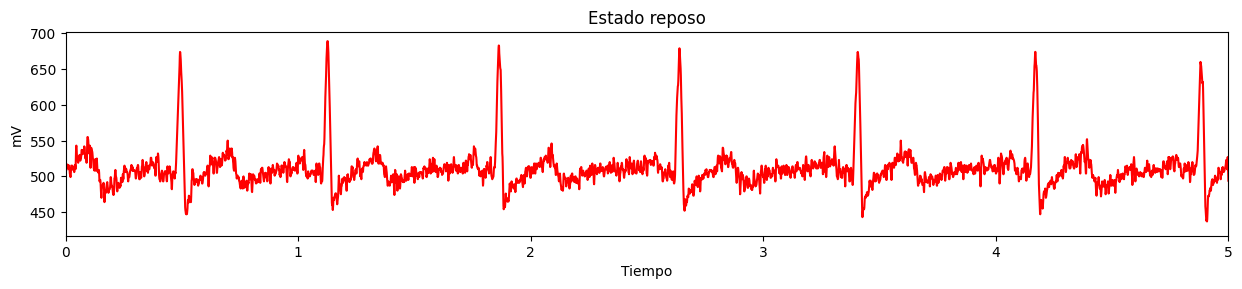

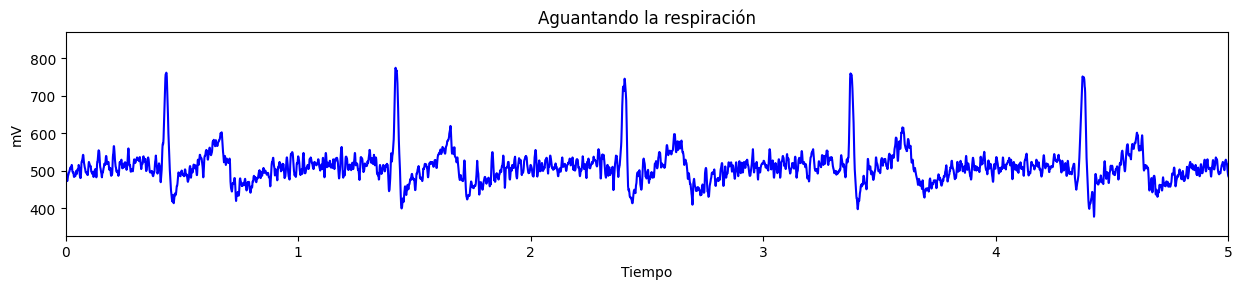

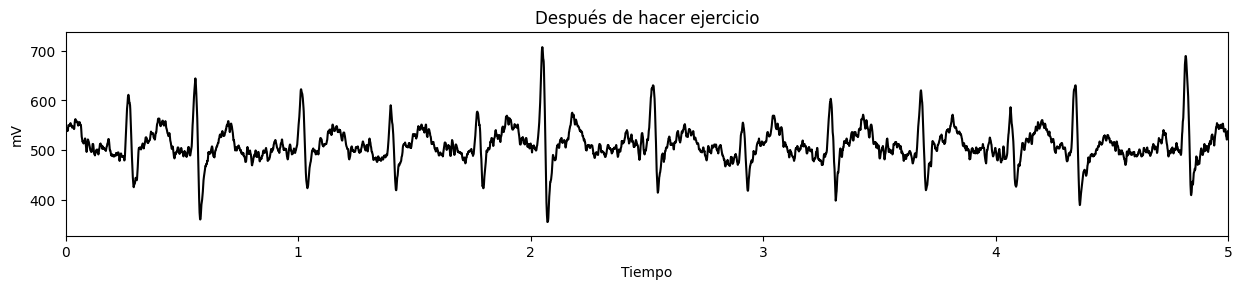

In [110]:
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
#número de muestras para cada señal
n_reposo = np.arange(0,len(d_reposo))  # t = n*Ts
n_respiracion = np.arange(0,len(d_respiracion ))
n_ejercicio = np.arange(0,len(d_ejercicio ))

#tiempo de cada señal
t_reposo = n_reposo*Ts
t_respiracion = n_respiracion*Ts
t_ejercicio = n_ejercicio*Ts

plt.figure(figsize=(15, 9));plt.subplot(3,1,1);plt.plot(t_reposo,d_reposo,'r');plt.title('Estado reposo');plt.xlabel('Tiempo');plt.ylabel('mV');plt.xlim(0,5)
plt.figure(figsize=(15, 9));plt.subplot(3,1,2);plt.plot(t_respiracion,d_respiracion,'b');plt.title('Aguantando la respiración');plt.xlabel('Tiempo'), plt.ylabel('mV');plt.xlim(0,5)
plt.figure(figsize=(15, 9));plt.subplot(3,1,3);plt.plot(t_ejercicio,d_ejercicio,'k');plt.title('Después de hacer ejercicio');plt.xlabel('Tiempo'), plt.ylabel('mV');plt.xlim(0,5)

## Vamos a graficar las señales en el dominio de la frecuencia:


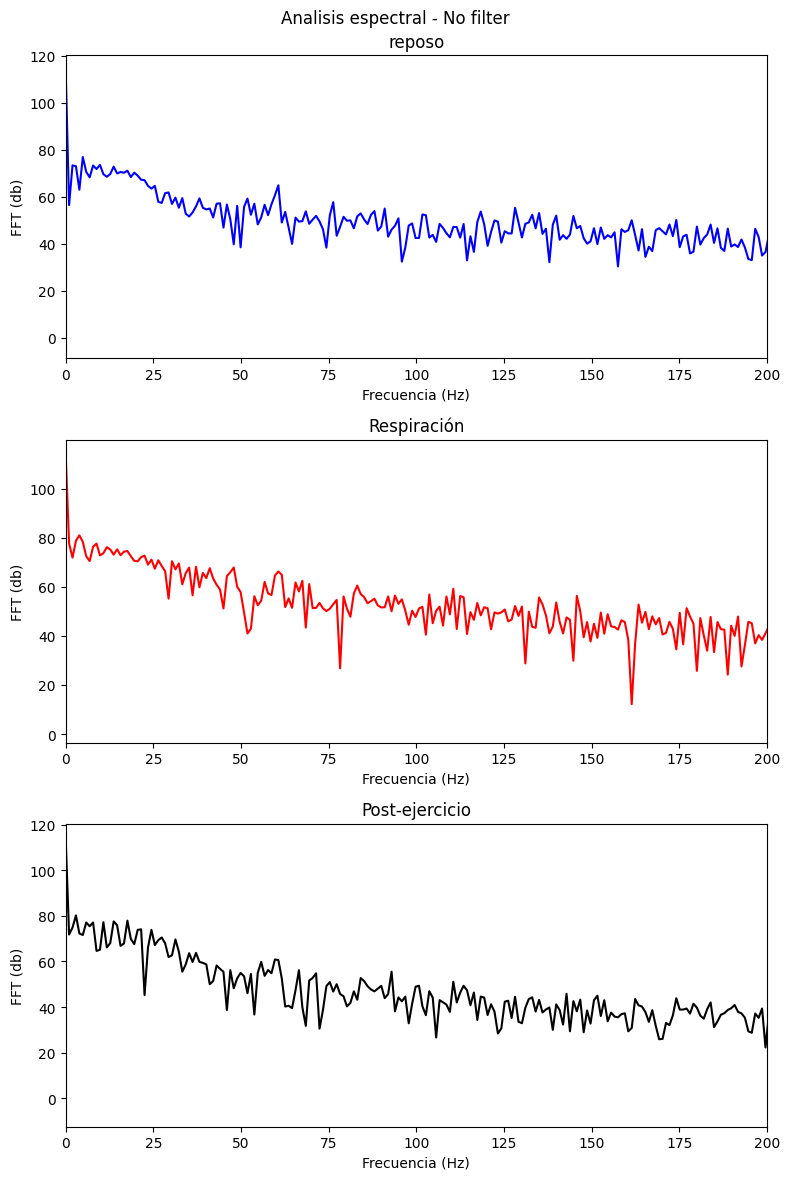

In [111]:
bx,by = fft_ECG(d_reposo); rx,ry = fft_ECG(d_respiracion); px,py = fft_ECG(d_ejercicio)

fig, axs=plt.subplots(3,1,figsize=(8,12))
plt.suptitle('Analisis espectral - No filter')
axs[0].plot(bx,by, 'b'); axs[0].set(title = 'reposo', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[1].plot(rx,ry, 'r'); axs[1].set(title = 'Respiración', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
axs[2].plot(px,py, 'k'); axs[2].set(title = 'Post-ejercicio', ylabel = 'FFT (db)', xlabel = 'Frecuencia (Hz)', xlim = (0,200))
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Estado en reposo')

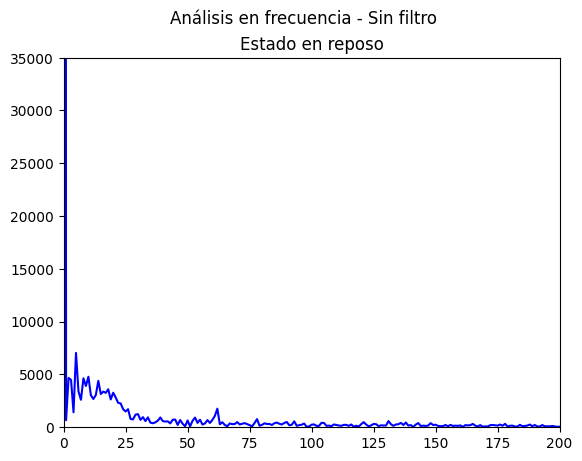

In [112]:
#Realizamos el análisis en frecuencia
N=2**10 # 10 bits
X4 = np.fft.fft(d_reposo,N)
X4 = X4[0:N//2]
X4m = np.abs(X4)
F = np.linspace(0,Fs/2,N//2)
F, 20*np.log10(X4m)

N=2**10 # 10 bits
X5 = np.fft.fft(d_respiracion,N)
X5 = X5[0:N//2]
X5m = np.abs(X5)
F = np.linspace(0,Fs/2,N//2)
F, 20*np.log10(X5m)

N=2**10 # 10 bits
X6 = np.fft.fft(d_ejercicio,N)
X6 = X6[0:N//2]
X6m = np.abs(X6)
F = np.linspace(0,Fs/2,N//2)
F, 20*np.log10(X6m)

plt.suptitle('Análisis en frecuencia - Sin filtro')
plt.plot(abs(X4),'b');plt.xlim(0,200);plt.ylim(0,35000);plt.title('Estado en reposo')



Text(0.5, 1.0, 'Estado de respiración')

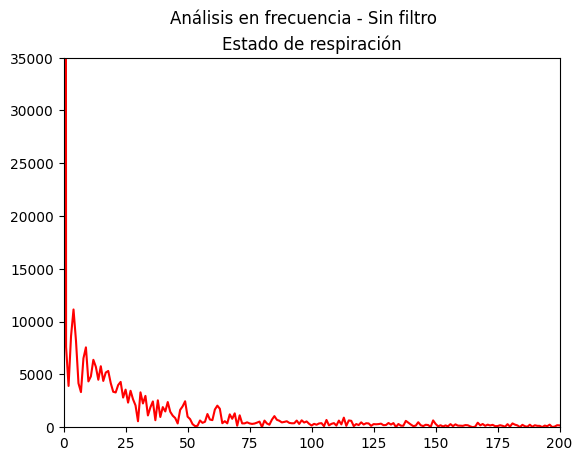

In [113]:
plt.suptitle('Análisis en frecuencia - Sin filtro')
plt.plot(abs(X5),'r');plt.xlim(0,200);plt.ylim(0,35000);plt.title('Estado de respiración')

Text(0.5, 1.0, 'Estado luego del ejercicio físico')

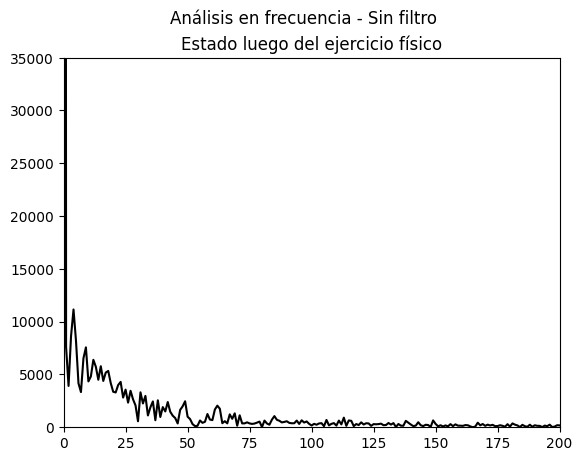

In [114]:
plt.suptitle('Análisis en frecuencia - Sin filtro')
plt.plot(abs(X5),'k');plt.xlim(0,200);plt.ylim(0,35000);plt.title('Estado luego del ejercicio físico')

#Realizaremos un filtro IIR-Butterworth:

In [115]:
#calculamos el orden de filtro y la frecuencia de corte sugerida
wp=94
ws=157

N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies
fc = np.round(Wc/(2*np.pi) ,2)

print(f"Orden del filtro: {N_ord}")
print(f"Frecuencia de corte calculada: {fc} hz")


Orden del filtro: 9
Frecuencia de corte calculada: 14.96 hz


[5.43211327e-09 9.92632183e-08 9.05729046e-07 ... 5.21383457e+02
 5.21387339e+02 5.21375580e+02]


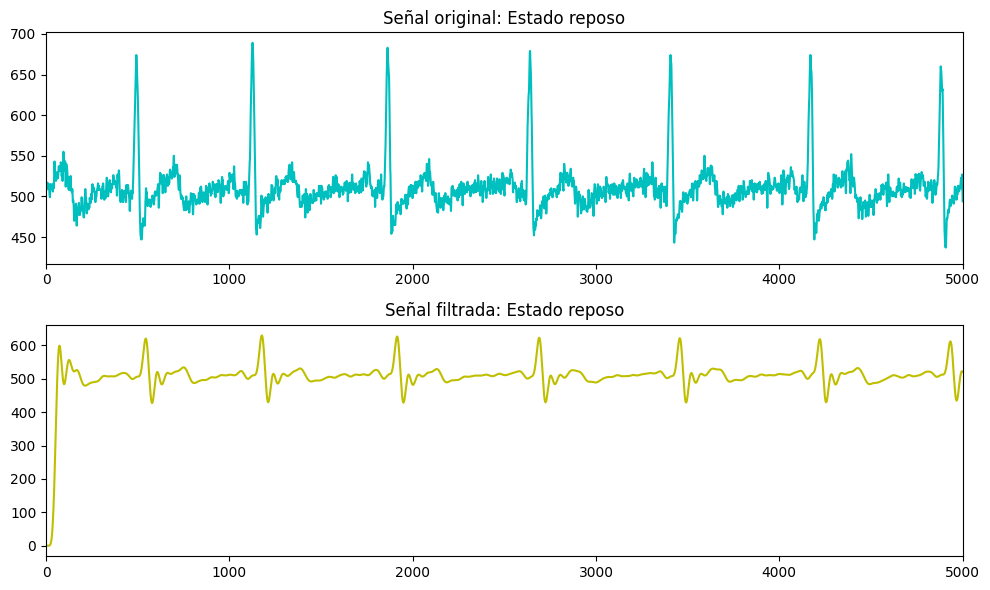

In [116]:
#usamos la frecuencia de corte sugerida, fc=20.
#Estado de reposo
segnal=d_reposo
Wc=20*2*np.pi
Fs=1000
N_ord=9
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')
bd, ad = signal.bilinear(b,a,Fs)
#Aplicamos el filtro en la señal
z= signal.lfilter(bd,ad, segnal)

t=np.arange(0,len(z))
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1);plt.plot(t,segnal,'c');plt.title('Señal original: Estado reposo');plt.xlim(0,5000)
plt.subplot(2, 1, 2);plt.plot(t,z,'y');plt.title('Señal filtrada: Estado reposo');plt.xlim(0,5000)
print(z)
plt.tight_layout()


[5.33644004e-09 9.75464591e-08 8.90320832e-07 ... 5.16166363e+02
 5.15134829e+02 5.14102442e+02]


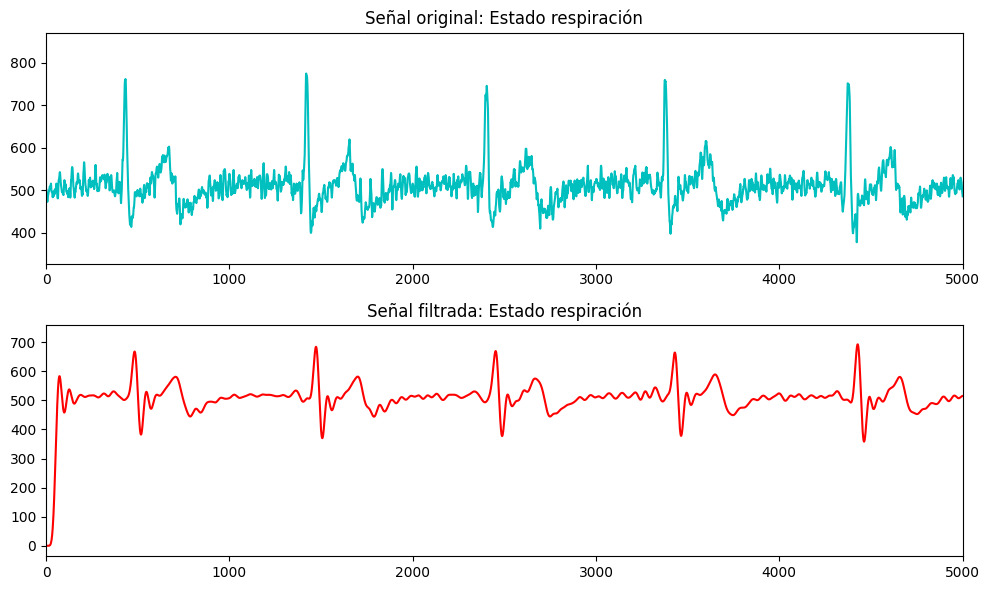

In [117]:
#Repetimos para los demás estados
#Estado de respiración
segnal=d_respiracion
Wc=20*2*np.pi
Fs=1000
N_ord=9
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')
bd, ad = signal.bilinear(b,a,Fs)
z= signal.lfilter(bd,ad, segnal)

t=np.arange(0,len(z))
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1);plt.plot(t,segnal,'c');plt.title('Señal original: Estado respiración');plt.xlim(0,5000)
plt.subplot(2, 1, 2);plt.plot(t,z,'r');plt.title('Señal filtrada: Estado respiración');plt.xlim(0,5000)
print(z)
plt.tight_layout()

[5.77228474e-09 1.05523163e-07 9.63260698e-07 ... 5.21333452e+02
 5.20654701e+02 5.20074162e+02]


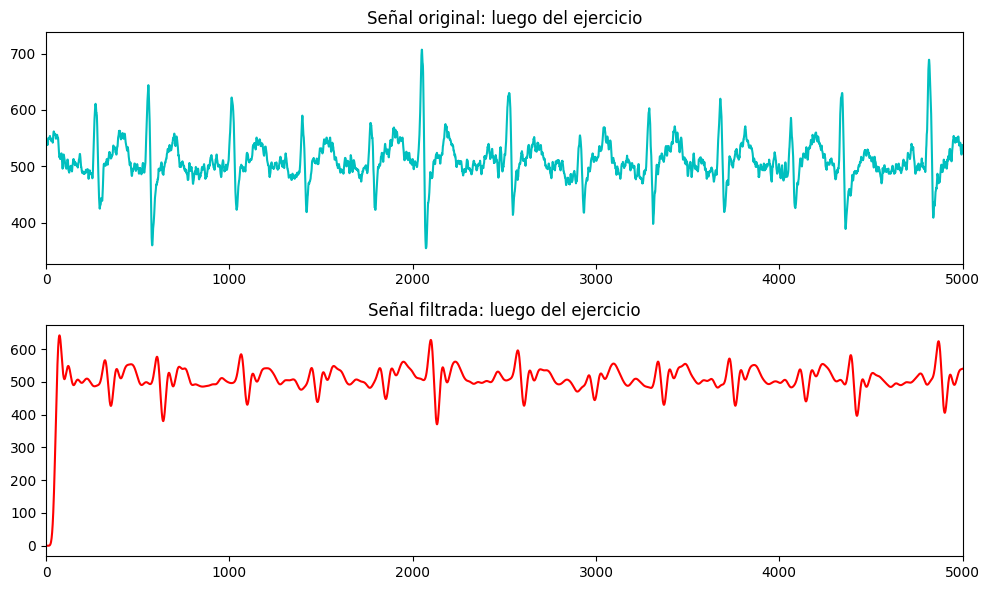

In [118]:
#Repetimos para los demás estados
#Estado de respiración
segnal=d_ejercicio
Wc=20*2*np.pi
Fs=1000
N_ord=9
b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')
bd, ad = signal.bilinear(b,a,Fs)
z= signal.lfilter(bd,ad, segnal)

t=np.arange(0,len(z))
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1);plt.plot(t,segnal,'c');plt.title('Señal original: luego del ejercicio');plt.xlim(0,5000)
plt.subplot(2, 1, 2);plt.plot(t,z,'r');plt.title('Señal filtrada: luego del ejercicio');plt.xlim(0,5000)
print(z)
plt.tight_layout()

# Realizaremos un filtro pasa baja FIR

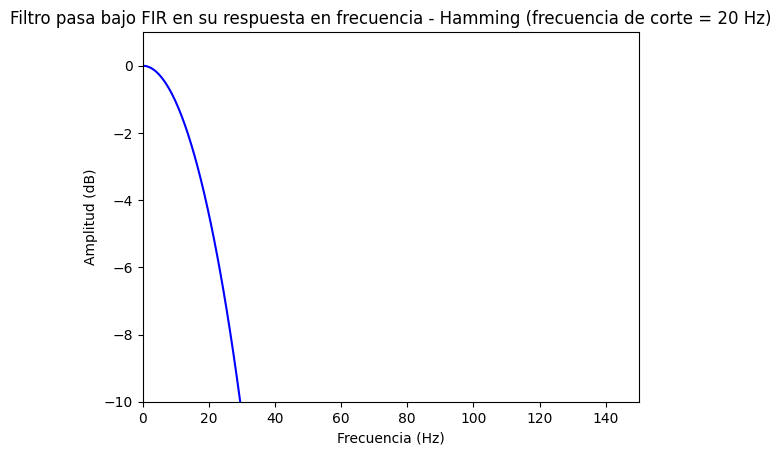

In [119]:
#longitud de la ventana
M = 50
#frecuencia de corte en Hz
Fc = 20

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/Fs

# filtro fir
k = firwin(numtaps=M, cutoff=Fc, window='hamming', fs=Fs)
w, h = signal.freqz(k, 1)
freq = w / (2 * np.pi) * Fs
amp = 20 * np.log10(np.abs(h))
plt.plot(freq, amp,'b')
plt.title(f"Filtro pasa bajo FIR en su respuesta en frecuencia - Hamming (frecuencia de corte = {Fc} Hz)")
plt.xlim(0,150)
plt.ylim(-10,1)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.show()

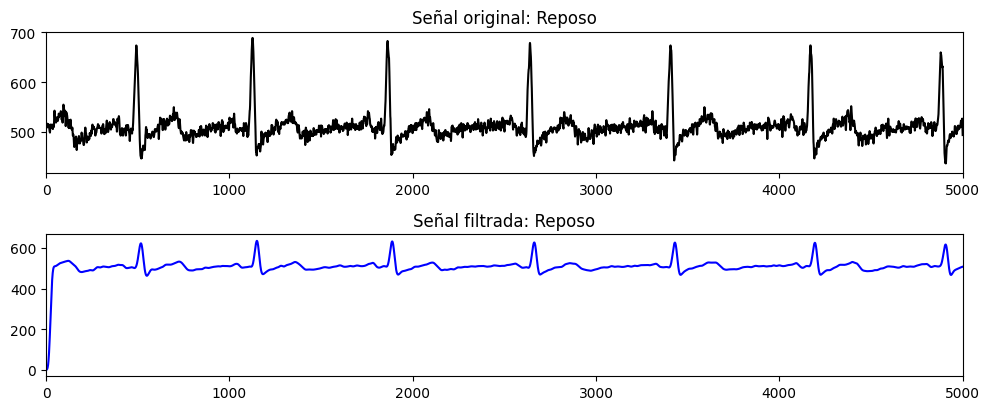

In [120]:
#aplicamos el filtro
segnal_2=d_reposo
y = lfilter(k, np.array(1),segnal_2)
t=np.arange(0,len(y))

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: Reposo');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y,'b');plt.title('Señal filtrada: Reposo');plt.xlim(0,5000)
plt.tight_layout()


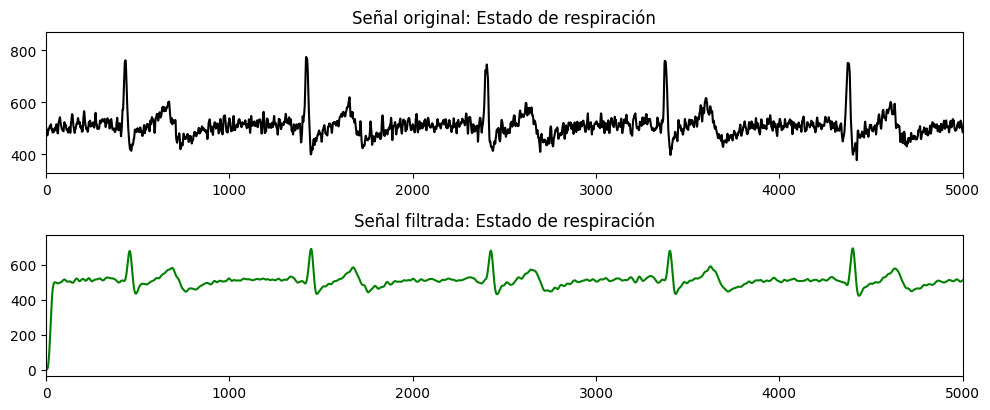

In [121]:
#aplicamos el filtro para otro estado
#Estado de respiración
segnal_2=d_respiracion
y_respiracion = lfilter(k, np.array(1),segnal_2)
t=np.arange(0,len(y_respiracion))

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: Estado de respiración');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y_respiracion,'g');plt.title('Señal filtrada: Estado de respiración');plt.xlim(0,5000)
plt.tight_layout()

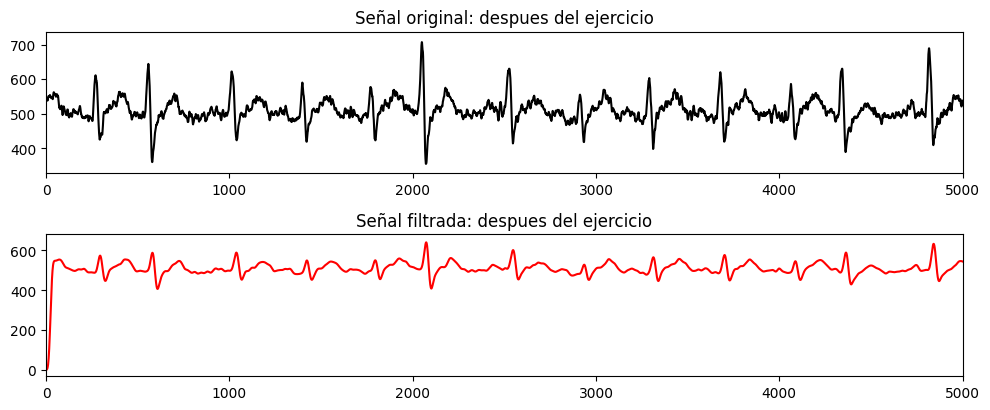

In [122]:
#Estado despues del ejercicio
segnal_2=d_ejercicio
y_ejercicio = lfilter(k, np.array(1),segnal_2)
t=np.arange(0,len(y_ejercicio))


plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: despues del ejercicio');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y_ejercicio,'r');plt.title('Señal filtrada: despues del ejercicio');plt.xlim(0,5000)
plt.tight_layout()

#Ahora utilizaremos una ventana rectangular en nuestro filtro FIR:

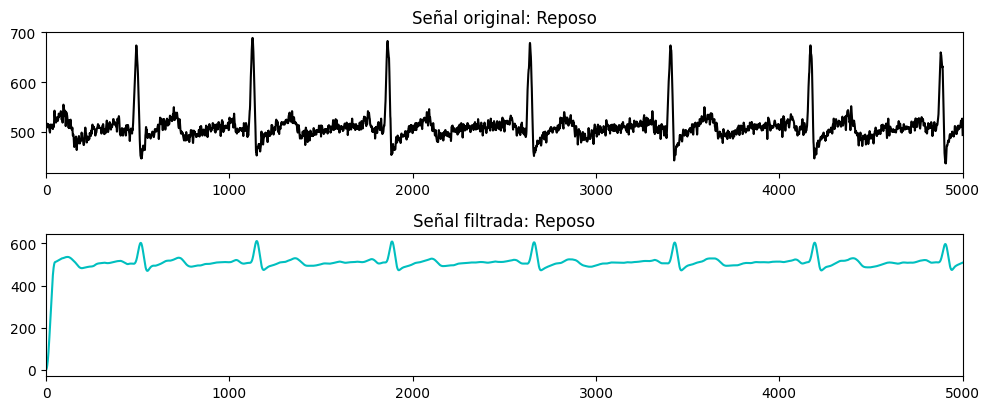

In [123]:
k_2 = firwin(numtaps=M, cutoff=Fc, window='boxcar', fs=Fs)

segnal_2=d_reposo
y_reposo = lfilter(k_2, np.array(1),segnal_2)
t=np.arange(0,len(y_reposo))

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: Reposo');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y_reposo,'c');plt.title('Señal filtrada: Reposo');plt.xlim(0,5000)
plt.tight_layout()


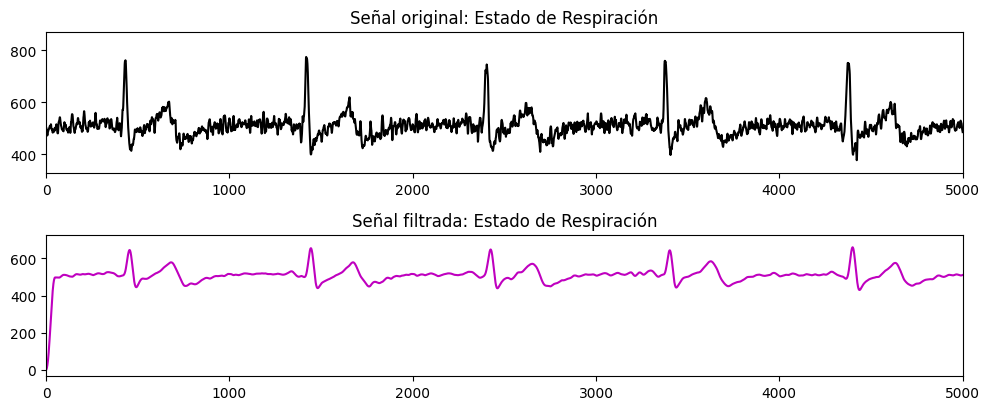

In [124]:
#Estado respiracion
segnal_2=d_respiracion
y_respiracion = lfilter(k_2, np.array(1),segnal_2)
t=np.arange(0,len(y_respiracion))

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: Estado de Respiración');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y_respiracion,'m');plt.title('Señal filtrada: Estado de Respiración');plt.xlim(0,5000)
plt.tight_layout()

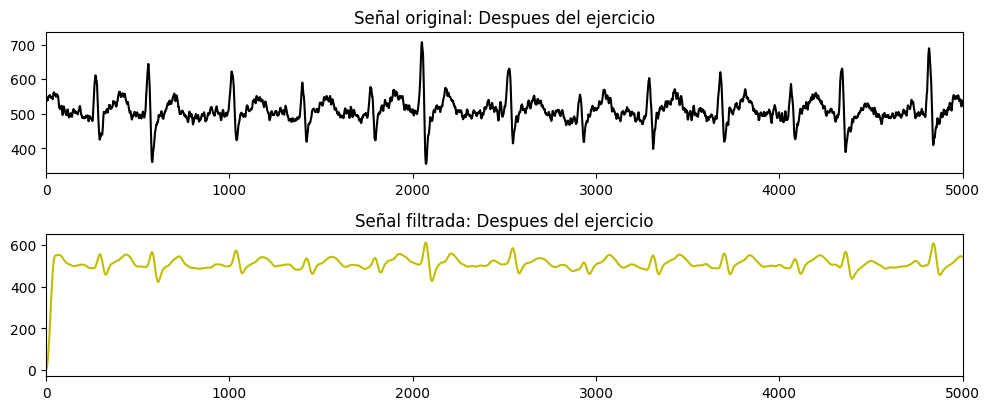

In [125]:
#Estado despues de ejercicio
segnal_2=d_ejercicio
y_ejercicio = lfilter(k_2, np.array(1),segnal_2)
t=np.arange(0,len(y_ejercicio))

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1);plt.plot(t,segnal_2,'k');plt.title('Señal original: Despues del ejercicio');plt.xlim(0,5000)
plt.subplot(3, 1, 2);plt.plot(t,y_ejercicio,'y');plt.title('Señal filtrada: Despues del ejercicio');plt.xlim(0,5000)
plt.tight_layout()